In [44]:
library(dummies)
library(data.table)
library(randomForest)
library(party)
library(e1071)
library(dbscan)
library(cluster)

In [21]:
data <- read.csv('Indian_Liver_Patient_Dataset.csv', header = TRUE)
data <- na.omit(data)
names(data)[1] <- paste('age')
names(data)[2] <- paste('gender')
names(data)[3] <- paste('total_bilirubin')
names(data)[4] <- paste('direct_bilirubin')
names(data)[5] <- paste('alkaline_phosphate')
names(data)[6] <- paste('alamine_aminotransferase')
names(data)[7] <- paste('Aspartate_Aminotransferase')
names(data)[8] <- paste('Total_Protiens')
names(data)[9] <- paste('Albumin')
names(data)[10] <- paste('Albumin_and_Globulin_Ratio')
names(data)[11] <- paste('Dataset')
data <- dummy.data.frame(data, names=c('gender'), sep='_')

In [22]:
data$Dataset[data$Dataset == 1] <- 0
data$Dataset[data$Dataset == 2] <- 1
class0 <- data[which(data$Dataset == 0),]
class1 <- data[which(data$Dataset == 1),]

In [23]:
noise <- function(class){
    sample_rows = sample(1:nrow(class), 0.2*nrow(class), replace=FALSE, prob=NULL)
    temp_data <- class[sample_rows,] 
#     print(class$Dataset)
    return(as.numeric(rownames(temp_data)))
}

In [24]:
noise0 <- noise(class0)
for(i in noise0){
    class0[toString(i),]$Dataset = !class0[toString(i),]$Dataset
}
# print(class0$Dataset)
noise1 <- noise(class1)
for(i in noise1){
    class1[toString(i),]$Dataset = !class1[toString(i),]$Dataset
}
# print(class1$Dataset)
nrow(class0)
nrow(class1)
noise_indices <- c(noise0, noise1)
print(length(noise_indices))
mislabeled_data <- rbind(class0,class1)
indices <- as.numeric(rownames(mislabeled_data))
str(mislabeled_data)

[1] 413

[1] 165

[1] 115
'data.frame':	578 obs. of  12 variables:
 $ age                       : int  62 62 58 72 46 26 29 55 57 72 ...
 $ gender_Female             : int  0 0 0 0 0 1 1 0 0 0 ...
 $ gender_Male               : int  1 1 1 1 1 0 0 1 1 1 ...
 $ total_bilirubin           : num  10.9 7.3 1 3.9 1.8 0.9 0.9 0.7 0.6 2.7 ...
 $ direct_bilirubin          : num  5.5 4.1 0.4 2 0.7 0.2 0.3 0.2 0.1 1.3 ...
 $ alkaline_phosphate        : int  699 490 182 195 208 154 202 290 210 260 ...
 $ alamine_aminotransferase  : int  64 60 14 27 19 16 14 53 51 31 ...
 $ Aspartate_Aminotransferase: int  100 68 20 59 14 12 11 58 59 56 ...
 $ Total_Protiens            : num  7.5 7 6.8 7.3 7.6 7 6.7 6.8 5.9 7.4 ...
 $ Albumin                   : num  3.2 3.3 3.4 2.4 4.4 3.5 3.6 3.4 2.7 3 ...
 $ Albumin_and_Globulin_Ratio: num  0.74 0.89 1 0.4 1.3 1 1.1 1 0.8 0.6 ...
 $ Dataset                   : num  1 0 1 0 1 0 1 0 0 0 ...
 - attr(*, "dummies")=List of 1
  ..$ gender: int  2 3


Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"Warning message:
"did not converge in 10 iterations"

 [1] 102399634  63925335  42476473  26407869  19394358  14438506  12641331
 [8]  11275193  10067841   9417269   9130648   8764360   8516837   8364725
[15]   8147560   7146767   6763788   6955262   7647213   6613261   6832922
[22]   6634497   4959343   6736047   4976347


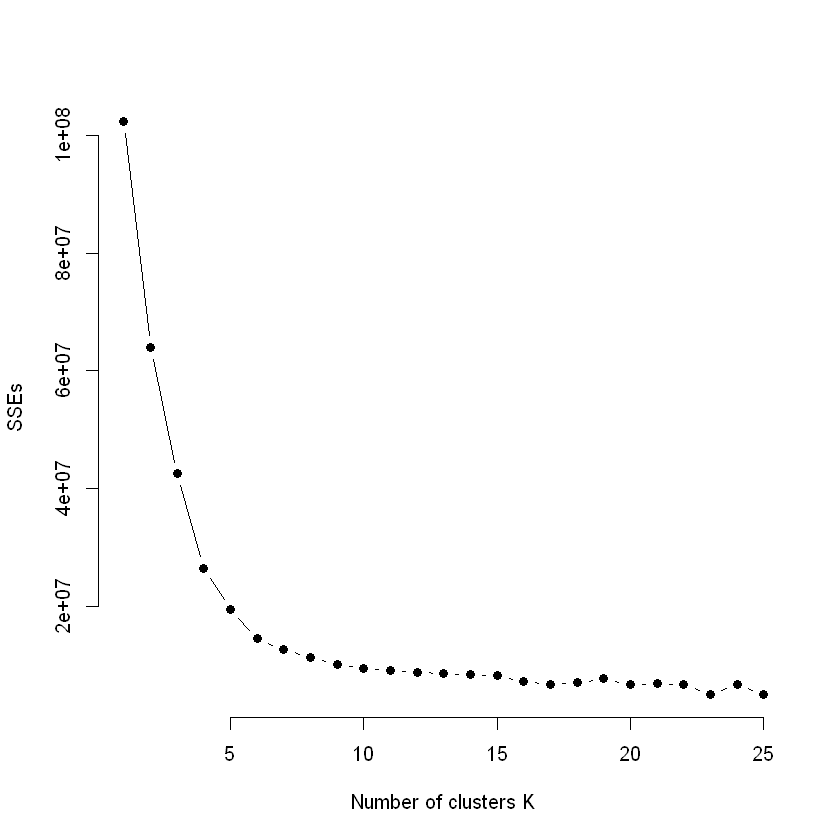

In [25]:
#Elbow_plot
k <- c(1:25)
SSE <- c()
for(i in k){
    clusters <- kmeans(mislabeled_data, i, nstart = 25)
    SSE <- c(SSE, clusters$tot.withinss)
}
print(SSE)
plot(k,SSE,type = "b", pch = 19, frame = FALSE, 
       xlab = "Number of clusters K",
       ylab = "SSEs")

In [26]:
# From above cluster analysis (Elbow Plot) we can conclude optimal number of clusters to be 6
temp <- mislabeled_data
temp$Dataset <- NULL
# summary(temp)
km <- kmeans(temp, 2,nstart=10)
# summary(km)
# print(km$cluster)
mislabeled_data$clusters=km$cluster 

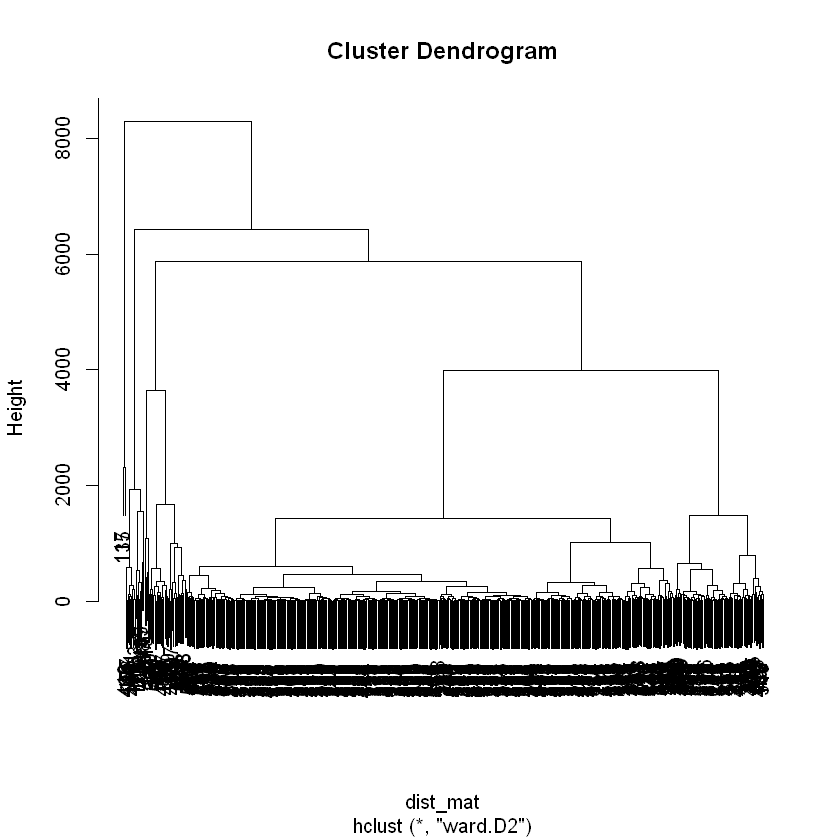

In [27]:
dist_mat <- dist(mislabeled_data, method='euclidean')
clusterC <- hclust(dist_mat, method = 'ward.D2')
plot(clusterC)
clusterC_vector <- cutree(clusterC, k = 2)

In [28]:
#oneHotencoding
mislabeled_data <- dummy.data.frame(mislabeled_data, names=c('clusters'), sep='_')
str(mislabeled_data)
head(mislabeled_data,3)

'data.frame':	578 obs. of  14 variables:
 $ age                       : int  62 62 58 72 46 26 29 55 57 72 ...
 $ gender_Female             : int  0 0 0 0 0 1 1 0 0 0 ...
 $ gender_Male               : int  1 1 1 1 1 0 0 1 1 1 ...
 $ total_bilirubin           : num  10.9 7.3 1 3.9 1.8 0.9 0.9 0.7 0.6 2.7 ...
 $ direct_bilirubin          : num  5.5 4.1 0.4 2 0.7 0.2 0.3 0.2 0.1 1.3 ...
 $ alkaline_phosphate        : int  699 490 182 195 208 154 202 290 210 260 ...
 $ alamine_aminotransferase  : int  64 60 14 27 19 16 14 53 51 31 ...
 $ Aspartate_Aminotransferase: int  100 68 20 59 14 12 11 58 59 56 ...
 $ Total_Protiens            : num  7.5 7 6.8 7.3 7.6 7 6.7 6.8 5.9 7.4 ...
 $ Albumin                   : num  3.2 3.3 3.4 2.4 4.4 3.5 3.6 3.4 2.7 3 ...
 $ Albumin_and_Globulin_Ratio: num  0.74 0.89 1 0.4 1.3 1 1.1 1 0.8 0.6 ...
 $ Dataset                   : num  1 0 1 0 1 0 1 0 0 0 ...
 $ clusters_1                : int  1 1 1 1 1 1 1 1 1 1 ...
 $ clusters_2                : int  0 0 0

age,gender_Female,gender_Male,total_bilirubin,direct_bilirubin,alkaline_phosphate,alamine_aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset,clusters_1,clusters_2
62,0,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1,1,0
62,0,1,7.3,4.1,490,60,68,7.0,3.3,0.89,0,1,0
58,0,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1,1,0


In [29]:
# RandomForestClassifier
set.seed(100)  # setting seed to reproduce results of random sampling
trainingRowIndex <- sample(1:nrow(data), 0.67*nrow(data))  # row indices for training data
trainingData <- mislabeled_data[trainingRowIndex, ]  # model training data
xtest <- mislabeled_data
# xtrain$Dataset <- NULL
testData  <- mislabeled_data[-trainingRowIndex, ]   # test data
trainingData$Dataset <- as.logical(trainingData$Dataset)
rf <- randomForest(as.factor(Dataset) ~ ., data=trainingData)
predicted = predict(rf,xtest) 
summary(predicted)
str(predicted)


FALSE  TRUE 
  405   173

 Factor w/ 2 levels "FALSE","TRUE": 1 1 2 1 2 1 1 1 1 1 ...
 - attr(*, "names")= chr [1:578] "1" "2" "3" "4" ...


In [40]:
mislabeled_data$predicted = predicted
# str(mislabeled_data)
# mislabeled_data$predicted<-as.numeric(mislabeled_data$predicted)
a<-as.numeric(mislabeled_data$predicted)
b<-mislabeled_data$Dataset
# print(a)
# print(b)
a <- na.omit(a)
b <- na.omit(b)
length(a)
length(b)
detected <- c()
count <- 0
for(i in indices){
    if(is.na(a[i])){
        print('mil gaya')
        print(i)
        print(a[i])
        break
    }
    
    if (a[i] != (b[i]+1)){
        detected <- c(detected,i)
        }
}
print(a!=b)
for(i in detected){
    if (i %in% noise_indices){
        count=count+1
    }
}
print(count)
print(length(noise_indices))

[1] 578

[1] 578

[1] "mil gaya"
[1] 579
[1] NA
  [1] FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE
 [13]  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [25]  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [37]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [49]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE
 [61]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE
 [73]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [85]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [97]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[109]  TRUE  TRUE  TRUE  TRUE FALSE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE
[121]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[133]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE
[145]  TRUE  TRUE  TRUE  TRUE  TRU

In [42]:
detected
length(detected)

[1]   1   7  50  58  70 113 116 119 139 144 188 196 208 231 232 243 248 256 261
[20] 280 289 336 337 353 380 412 415 425 430 440 442 451 458 462 463 477 503 506
[39] 507 518 520 543 547 552 565 569 570 571 575 576

[1] 50

In [19]:

# Fitting model
fit <-naiveBayes(trainingData$Dataset ~ ., data = trainingData)
summary(fit)
#Predict Output 
x_test <- mislabeled_data
x_test$Dataset <- NULL 
predicted = predict(fit,x_test)

        Length Class  Mode   
apriori  2     table  numeric
tables  13     -none- list   
levels   2     -none- logical
call     4     -none- call   

In [415]:
mislabeled_data$predicted=predicted
detected <- c()
count <- 0
for(i in indices){
    if(mislabeled_data$Dataset[i] != mislabeled_data$predicted[i]){
        detected<-c(detected,i)
        }
}        
for(i in detected){
    if (i %in% noisy_indices){
        cnt=cnt+1
    }
}
print(cnt,len(noisy_indices))

ERROR: Error in if (mislabeled_data$Dataset[i] != mislabeled_data$predicted[i]) {: missing value where TRUE/FALSE needed


Warning message:
"did not converge in 10 iterations"

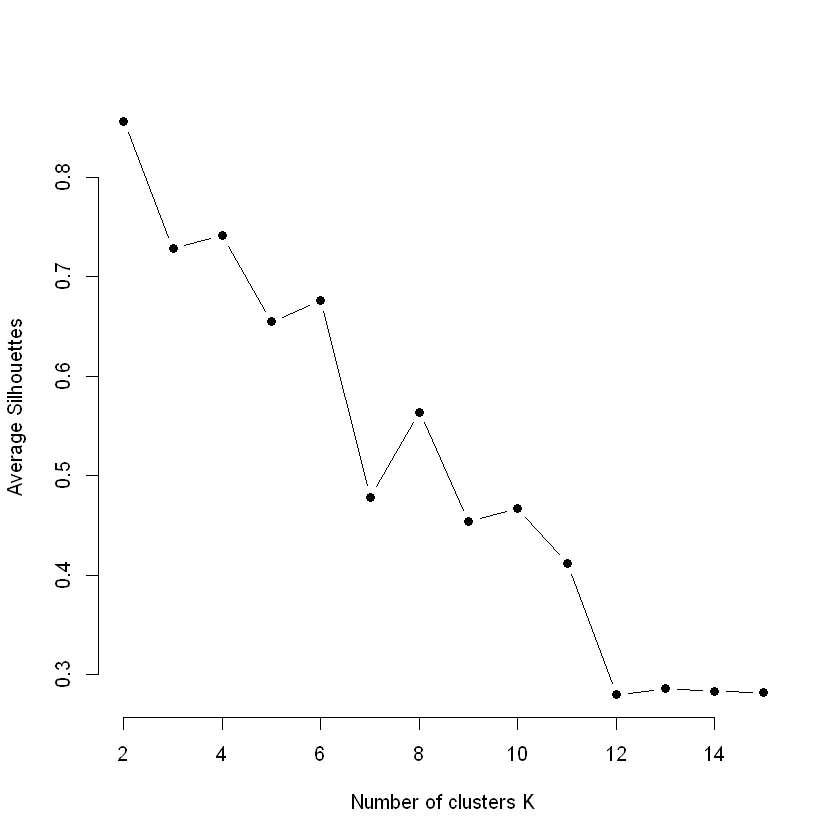

In [520]:
avg_sil <- function(k) {
  km.res <- kmeans(mislabeled_data, k, nstart = 25)
  ss <- silhouette(km.res$cluster, dist(mislabeled_data))
  mean(ss[, 3])
}

# Compute and plot wss for k = 2 to k = 15
k.values <- 2:15
avg_sil_values <- c()
# extract avg silhouette for 2-15 clusters
for(i in k.values){
    avg_sil_values <- c(avg_sil_values,avg_sil(i))
}


plot(k.values, avg_sil_values,
       type = "b", pch = 19, frame = FALSE, 
       xlab = "Number of clusters K",
       ylab = "Average Silhouettes")

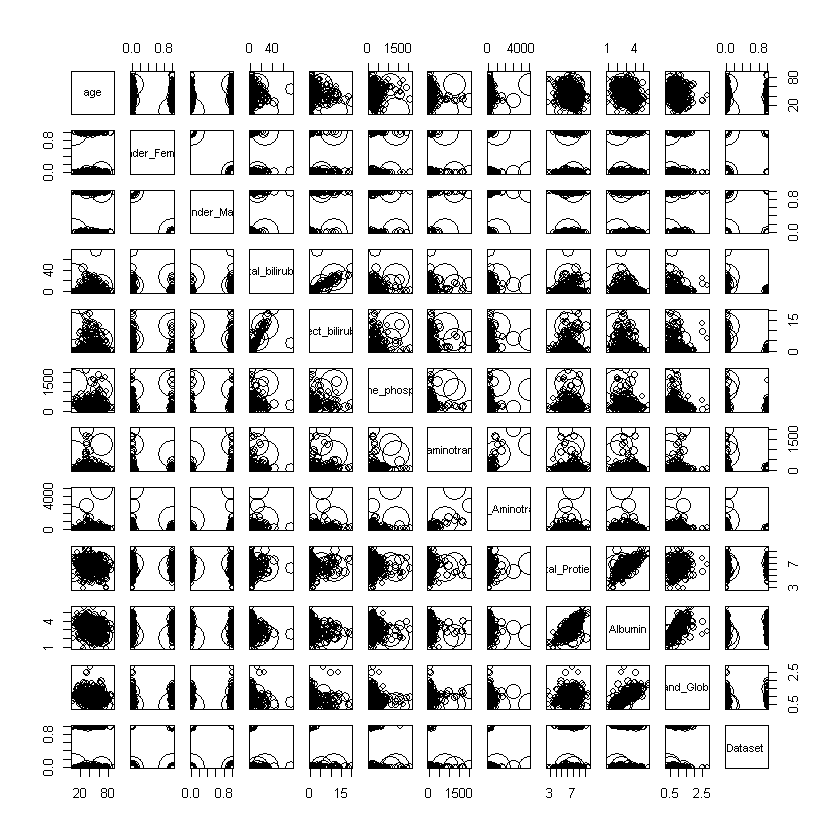

In [45]:
lof <- lof(as.matrix(data),k=5)
pairs(as.matrix(data), cex=lof)

In [82]:
mislabeled_data$predicted <- as.numeric(mislabeled_data$predicted)
db <- dbscan(as.matrix(data), eps=250, minPts=40)

In [83]:
print(db)

DBSCAN clustering for 578 objects.
Parameters: eps = 250, minPts = 40
The clustering contains 1 cluster(s) and 38 noise points.

  0   1 
 38 540 

Available fields: cluster, eps, minPts


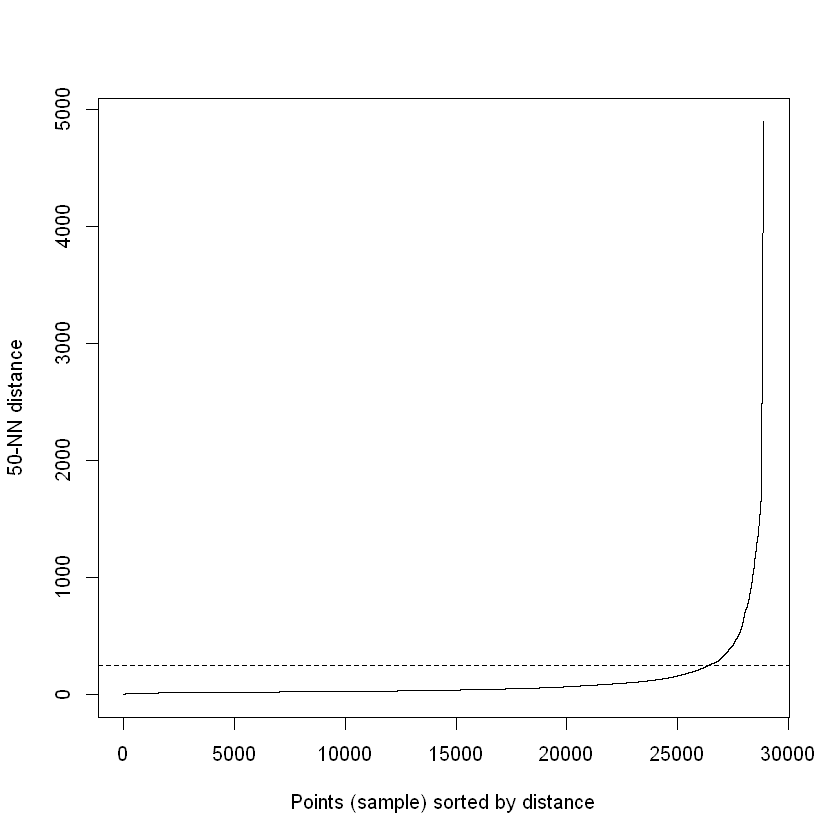

In [58]:
dbscan::kNNdistplot(mislabeled_data, k =  40)
abline(h = 250, lty = 2)

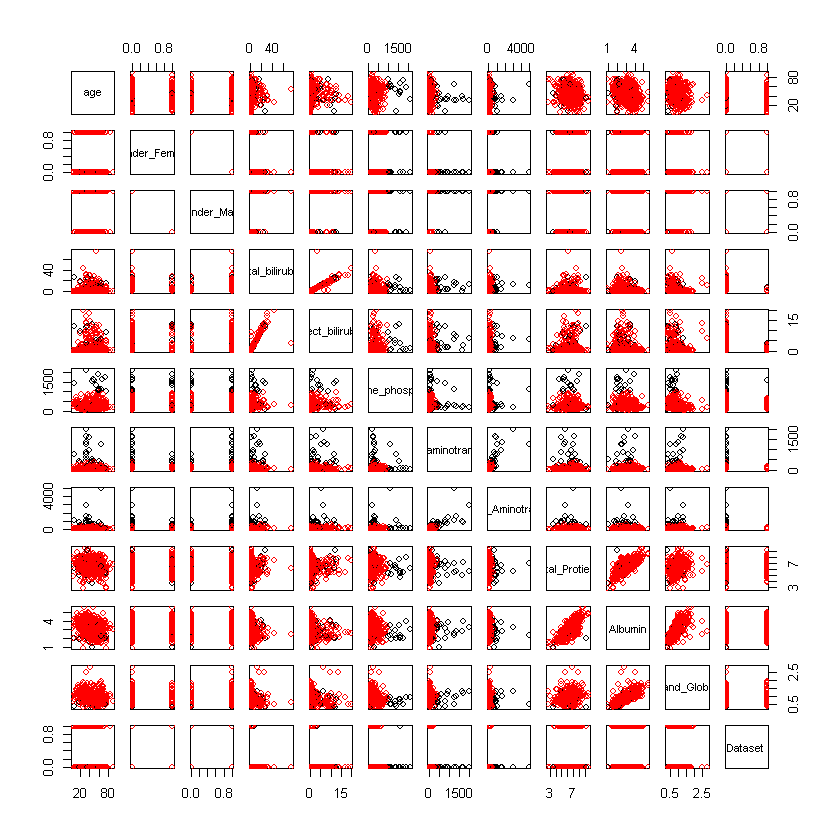

In [84]:
pairs(as.matrix(data), col = db$cluster + 1L)